Рассмотрим систему "груз + пружина + вязкое трение". 
Вход системы есть сила $f(t)$, имеющая импульсный закон с амплитудой $A$, длительность $t_0$ и периодом $t_0 + Δ t$:

$$
f(t) =  \left\{ \begin{aligned}
                &A, ∃ k \in \mathbb{N}_0: k(t_0 + Δ t) \leq t < k(t_0 + Δ t) + t_0 \\
                &0, \text{ иначе}
        \end{aligned} \right.
$$

In [92]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import integrate

In [93]:
def F( A, t0, dt, t ) :
    k = math.floor ( t / (t0 + dt) )
    if t < k * (t0 + dt) + t0 :
        return A
    else :
        return 0 

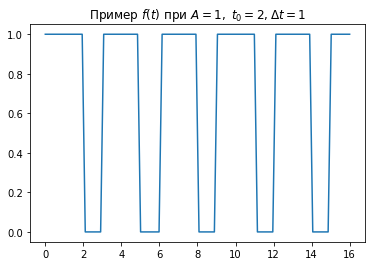

In [94]:
t_f = np.linspace (0, 16, 100)

f_arr = [ F( 1, 2, 1, t_f[i]) for i in  range(100) ]

plt.plot( t_f, f_arr )
plt.title("Пример $f(t)$ при $A=1, ~ t_0 = 2, \Delta t = 1 $")
plt.show()

Уравнение движения получаем
$$
f(t) = m x'' (t) + γ x'(t) + k x(t), ~ x(0) = x'(0) = 0
$$

Используя операторный метод в линейном приближении:
$$
\mathcal{L} [ f(t) ] (s) = \int_{0}^{∞} e^{-st} f(t) = A \sum_{k=0}^{\infty} \left( e^{ -sk(t_0 + \delta t) } - e^{-sk(t_0 + \delta t) - s t_0} \right) = \frac{A ( 1 - e^{s t_0})}{s(1 - e^{-s(t_0 + \delta t)})} 
$$
Пррименяя разложение по Тейлору до второго порядка:
$$
\mathcal{L} [f] (s) \sim \frac{ \tilde{A} }{s}
$$
где $\tilde{A} = \frac{1}{1 + \Delta t / t_0 }$

Тогда:
$$
\mathcal{L} [x] (s) = \frac{ \tilde{A} }{ s ( m s^2 + γ s + k ) } = \tilde{A} \left( \frac{r}{ s \left( \left( T s + \sigma \right)^2 + (1 - \sigma^2)  \right)   }  \right) 
$$
где:
$$
r = \frac{1}{k}, ~  T = \sqrt{ \frac{m}{k} }, ~ \sigma =  \frac{ γ }{ 2 \sqrt{mk} }
$$
В зависимости от $\sigma$ имеем 3 различные траектории:

$\sigma < 1$:
$$
x(t) = \tilde{A} r \left( 1 - e^{ -\sigma t / T } \left( \cos \left( \frac{\omega t}{T} \right) + \frac{\sigma}{\omega} \sin \left( \frac{\omega t}{T} \right)    \right)  \right)
$$
где $\omega = \sqrt{1 - \sigma^2}$

$\sigma = 1$ :
$$
x(t) = r  \tilde{A} \left( 1 - e^{ -\sigma t / T } \left( 1 + \frac{\sigma t}{T}  \right)  \right)
$$

$\sigma > 1$ :
$$
x(t) = \frac{ \tilde{A} r }{ \omega^2} \left( \cosh \left( \frac{\omega t}{T}  \right) - 1   \right),
$$
где $\omega = \sqrt{\sigma^2 -1}$

In [95]:
#right side equstion

def f(A, t0, dt, m, k, g, xv_vec, t,  ) :
    x, v = xv_vec
    return np.array ( [ v, (F(A, t0, dt, t) - g * v - k * x ) / m ] )

In [96]:

def solve_RK ( A, t0, dt, m, k, g , n_node, T, x0, v0 ) :
    t = np.linspace (0, T, n_node)
    h = t[1] - t[0]

    x = [ x0 for i in range ( n_node ) ]
    v = [ v0 for i in range ( n_node ) ]

    for i in range (0, n_node -1 ) :
        u_curr = np.array ( [ x[i], v[i] ] )
        k1 = f ( A, t0, dt, m, k, g, u_curr,  t[i] )
        k2 = f (A, t0, dt, m, k, g, u_curr + ( h / 3) * k1 , t[i] )
        k3 = f ( A, t0, dt, m, k, g, u_curr +  ( 2 * h / 3) * k2, t[i] )
        u_new = u_curr  + ( h / 4) * ( k1 + 3 * k3 )
        x[i+1] = u_new[0]
        v[i+1] = u_new[1]
    return x

In [97]:

def theoretical_solve ( tildeA, r, T, sigma, t ) :
    
    if 1 - sigma > 1e-3 :
        om = np.sqrt( 1 - sigma**2 )
        return tildeA * r * ( 1 - np.exp( -sigma*t/T ) * ( np.cos( om * t / T ) 
            +  sigma * np.sin( om * t / T ) / om   )  )

    if sigma - 1 > 1e-3:
        om = np.sqrt( sigma**2 - 1 )
        return (tildeA * r / om**2 )*( np.cosh (om * t / T ) - 1 )
    
    if  np.abs(sigma - 1.0 ) < 1e-3 :
        return  r*tildeA * ( 1 - np.exp( - t / T ) * ( 1 + sigma * t / T  )  )  


def assimpt (  tildeA, r, T, sigma, t ):
    return   ( tildeA * r / ( 1 - sigma**2 ) ) * np.exp( -sigma * t / T )  

In [100]:

def draw_trajectory( A, t0, dt, m, k, g, T_max, n_node, flag_num_sol) :
    t = np.linspace (0, T_max, n_node)

    tildeA = A / ( 1 + dt / t0 )
    r = 1 / k
    T = np.sqrt( m / k )
    sigma = g / ( 2 * np.sqrt( m*k ) )

    x_th = theoretical_solve ( tildeA, r, T, sigma, t )

    fig, ax = plt.subplots()
    if flag_num_sol :
        x = solve_RK( A, t0, dt, m, k, g , n_node, T_max, 0, 0 )
        ax.plot(t, x, color = 'b' ,label = 'numerical sol' )
    
    ax.plot( t, x_th, color = 'g' ,label = 'theoretical sol' )

    if (1 - sigma) > 1e-3 :
        ax.set_title('$\sigma < 1$')
    if ( sigma - 1 )  > 1e-3 :
        ax.set_title('$\sigma > 1 $')
    if np.abs(1 - sigma) < 1e-3 :
        ax.set_title('$ \sigma = 1 $')    

    if  2*np.sqrt( k*m) - g > 1e-3 :
    
        asmpt = tildeA * r 
        sc = asmpt
        bound_step =  - sigma / T
    
        x_asmpt = [ asmpt for i in range( n_node ) ] 
        x_temp = assimpt (  tildeA, r, T, sigma, t ) + asmpt
        ax.plot( t, x_temp, '--k' , label = 'UP_bound: $ x^{*}(t)=$'+
            str( round(sc,2) )+'exp('+ str( round(bound_step,2)) + 't)+'+ 
            str( round(asmpt,2)) )
        x_temp = -x_temp +  2*asmpt   
        ax.plot( t, x_temp, '--k' , label = 'Lower_bound: $ x_{*}(t)=-$'+
            str( round(sc,2) )+ 'exp('+ str( round(bound_step,2)) + 't)+'+ 
            str( round(asmpt,2)) )
        ax.plot ( t, x_asmpt, color = 'k', label = 'assmpt: x=' + 
             str( round(asmpt,2) ) )

    if np.abs( g - 2*np.sqrt( k*m) ) < 1e-3 :
        x_asmpt = [ tildeA for i in range( n_node ) ]
        ax.plot ( t, x_asmpt , color = 'k' , label = 'assmpt: x=' + 
             str(round(tildeA,2) ))

    ax.grid()

    ax.legend(shadow = True, fontsize = 14)
    

    fig.set_figwidth(10)
    fig.set_figheight(10)

    plt.show()





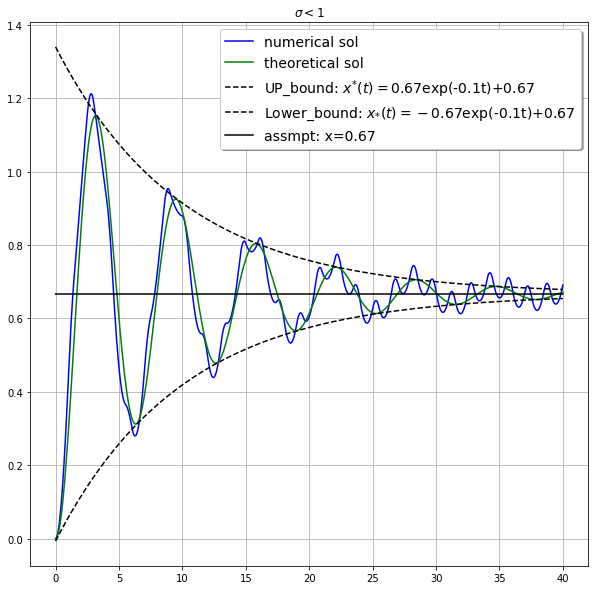

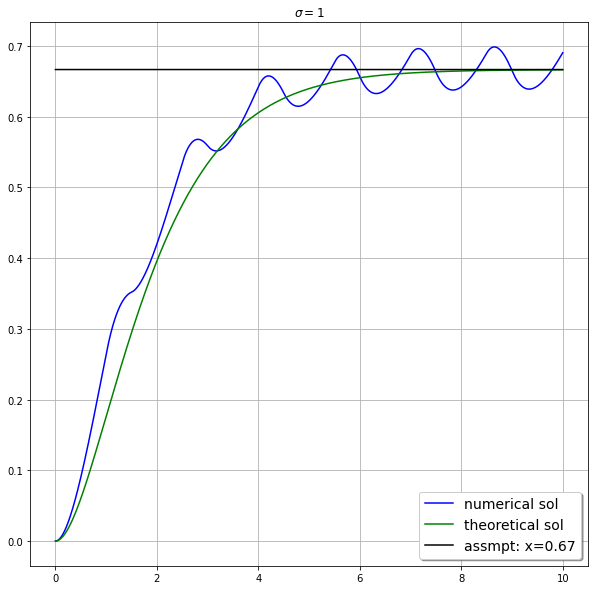

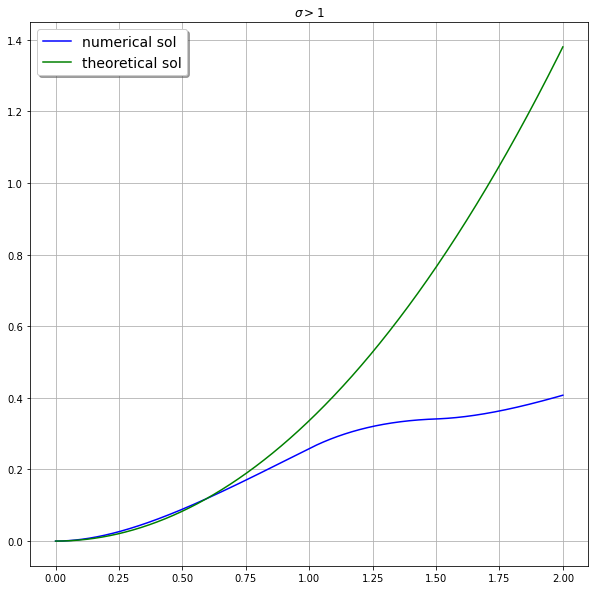

In [102]:
A = 1
t0 = 1
dt = 0.5
m = 1
k = 1

g = 0.2
draw_trajectory( A, t0, dt, m, k, g, 40, int(1e7), True )

g = 2
draw_trajectory( A, t0, dt, m, k, g, 10, int(1e7), True )

g = 2.1
draw_trajectory( A, t0, dt, m, k, g, 2, int(1e7), True )